# Lesson 7

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.fastai.learner import *
from fastai.fastai.column_data import *
from fastai.fastai.io import *
from fastai.fastai.lm_rnn import *

## 00:00:00 - Part 1 recap

* Part 1 theme = classification and regression with DL.
  * Identify and learning best practises.
* First 4 lessons: image classification, structured data and NLP in practise.
* Last 3 lessons: understanding more detail about what is going on under the hood.

## 00:01:01 - Part 2 preview

* Move from classification focus to generative models:
  * Chat responses.
  * Images.
  * Text.
* Move from best practises to speculative stuff:
  * Recent papers that haven't been fully tested.
* Learn how to read papers.

## 00:02:51 - RNNs (recap of Lesson 6)

* RNNs are just standard fully-connected networks.
* Recap of lesson from last week (see Lesson 6 notebook).

### 00:06:20 - Multi-output model

* Split into non-overlapping pieces, the use a piece to predict the next chars offset by 1.
* Problem with RNN model created earlier: each time we start a new sequence, we have to learn the hidden state from scratch:
  ```
  def forward(self, *cs):
      bs = cs[0].size(0)
      
      # Problem: we are created a brand new hidden state each forward prop
      h = V(torch.zeros(1, bs, n_hidden)
      
      inp = self.e(torch.stack(cs))
      outp, h = self.rnn(inp, h)
  ```
  * Can improve on that by saving the state of `self.h` in the constructor:

In [2]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        
        super().__init__()
        
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size[0]
        
        # This handles the last batch, if we don't have enough
        # text for a batch size.
        if self.h.size(1) != bs:
            self.init_hidden(bs)
            
        outp, h = self.rnn(self.e(cs), self.h)
        
        # Store results of hidden layer and throw away history of operations.
        # Called: backprop through time.
        self.h = repackage_var(h)
        
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(1, bs, n_hidden)))

### 00:10:50 - Backprop through time

* In multi-output model, unrolled RNN is going to be the size of the corpus. Eg if it's a million words, `self.h` would have a million layers, which would be expensive to run backprop etc.
  * Want to remember state but not history: `Variable(h.data) if type(h) == Variable else tuple(repackage_var(v) for v in h)`
    * By passing `h.data` into a new `Variable` class, you lose the history.
* Process of running back prop through hidden state history is backprop through time.
* Usually set a cap on how many layers to run bptt on.
  * In original RNN lesson, we had a var called `bptt = 70`, which sets how many layers to run backprop through.
* Longer values may let you capture more state about the problem, but may also results in exploding / vanishing gradients.

### 00:16:00 - Minibatching in RNNs

* How do you get the data into the model, given we want to do a mini-batch of sections?
* Reminder about how Torch text breaks up documents for batching:
  * Split the corpus into 64 equal sized chunks.
  * Stack the "chunks" - each mini batch splits the chunks of size `bptt`.

### 00:20:31 - Augmentation for NLP (audience question)

* No good way known: Jeremy planning to study it.
* Recent Kaggle winner won it by randomly inserting parts of rows.

### 00:21:38 - Choosing a `bptt` size (audience question)

* Question: how do you choose a `bptt` size?
* Answers:
  * Memory: Matrix size for a minibatch has a bptt x bs size, so pick one that your GPU can handle.
  * Stability: If training is unstable: loss shotting off to NaN can try reducing (less layers to gradient explode through).
  * Performance: Consider reducing if each batch is training too slowly.

## 00:23:24 - Training model with Torchtext tooling

* Back to Torchtext for preparing dataset.
* Have a choice when preparing dataset:
  * Write your own dataset subclass
  * Change your data to fit the dataset classes you have.

In [3]:
from torchtext import vocab, data

from fastai.fastai.nlp import *
from fastai.fastai.lm_rnn import *

PATH = 'data/nietzche/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'

TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

### Preparing dataset (not covered in lecture)

* Prepared data by copying nietzsche.txt data to `trn` and `val` folder, then deleting last 20% of rows in `trn` and deleted first 80% of rows in `val`.
* Useful to not have a random shuffled validation set: val set is actual ordered text.

In [8]:
!mkdir -p {TRN}

In [10]:
!mkdir -p {VAL}

In [11]:
get_data('https://s3.amazonaws.com/text-datasets/nietzsche.txt', f'{PATH}nietzsche.txt')

nietzsche.txt: 606kB [00:04, 133kB/s]                             


In [12]:
!wc -l {PATH}nietzsche.txt

    9934 data/nietzche/nietzsche.txt


In [13]:
# Use ceil over round because that line ends a sentence.
trn_rows = math.ceil(9934 * 0.8)

In [14]:
!head -n {trn_rows} {PATH}nietzsche.txt > {TRN}/train.txt

In [15]:
!tail -n 5 {TRN}/train.txt

that the easy life which the Jesuit manuals advocate is for the benefit,
not of the Jesuits but the laity. Indeed, it may be questioned whether
we enlightened ones would become equally competent workers as the result
of similar tactics and organization, and equally worthy of admiration as
the result of self mastery, indefatigable industry and devotion.


In [16]:
!tail -n {9934 - trn_rows} {PATH}nietzsche.txt > {VAL}/val.txt

In [17]:
!head -n 5 {VAL}/val.txt


56

=Victory of Knowledge over Radical Evil.=--It proves a material gain to
him who would attain knowledge to have had during a considerable period


* In Torchtext, you create a `Field`.
  * Description for how to process text.
  * `tokenize` - since you want a character model, can just use the list function in Python to tokenise:

In [18]:
list('yo wassup')

['y', 'o', ' ', 'w', 'a', 's', 's', 'u', 'p']

In [4]:
TEXT = data.Field(lower=True, tokenize=list)

* Settings:
  * `bs` - batch size (same setting as last notebook).
  * `bptt` - size of backprop through time.
  * `n_fac` - size of embedding.
  * `n_hidden` - size of hidden state.

In [5]:
bs=64; bptt=8; n_fac=42; n_hidden=256

* Create Fast.ai dataset:

In [6]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

* Length of data loader is how many batches to go through (should be equal to token num / batch size / bptt):

In [22]:
len(md.trn_ds[0].text) / bs / bptt

943.3046875

  * Not exactly that in Torchtext: bptt randomised a little bit:

In [23]:
len(md.trn_dl)

942

Num unique tokens:

In [24]:
md.nt

55

In [25]:
len(md.trn_ds), len(md.trn_ds[0].text)

(1, 482972)

* `TEXT` also contains an extra attribute called `vocab` containing:
  * list of all unique items in vocab (`TEXT.vocab.itos`).
  * reverse mapping from each item to number (`TEXT.vocab.stoi`).

In [26]:
TEXT.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 't',
 'i',
 'a',
 'o',
 'n',
 's',
 'r',
 'h',
 'l',
 'd',
 'c',
 'u',
 'f',
 'm',
 'p',
 'g',
 ',',
 'y',
 'w',
 'b',
 'v',
 '-',
 '.',
 '"',
 'k',
 'x',
 ';',
 ':',
 'q',
 'j',
 '!',
 '?',
 '(',
 ')',
 "'",
 'z',
 '1',
 '2',
 '=',
 '_',
 '3',
 '[',
 ']',
 '4',
 '5',
 '6',
 '8',
 '7',
 '9',
 '0',
 'ä']

In [27]:
TEXT.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index()>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             't': 4,
             'i': 5,
             'a': 6,
             'o': 7,
             'n': 8,
             's': 9,
             'r': 10,
             'h': 11,
             'l': 12,
             'd': 13,
             'c': 14,
             'u': 15,
             'f': 16,
             'm': 17,
             'p': 18,
             'g': 19,
             ',': 20,
             'y': 21,
             'w': 22,
             'b': 23,
             'v': 24,
             '-': 25,
             '.': 26,
             '"': 27,
             'k': 28,
             'x': 29,
             ';': 30,
             ':': 31,
             'q': 32,
             'j': 33,
             '!': 34,
             '?': 35,
             '(': 36,
             ')': 37,
             "'": 38,
             'z': 39,
             '1': 40,
             '2': 41,
             '=':

In [28]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        
        # Check for final batch (might not equal batch size)
        if self.h.size(1) != bs:
            self.init_hidden(bs)

        outp, h = self.rnn(self.e(cs), self.h)
        
        # Get rid of history
        self.h = repackage_var(h)
        
        # Have to use `.view` to make output rank 2 tensor which is what's required by loss func.
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = V(torch.zeros(1, bs, n_hidden))

In [29]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512)
opt = optim.Adam(m.parameters(), 1e-3)

* Output uses `.view` because loss function can't handle rank 3 tensors: has to be rank 2 (or rank 4).
* `dim` arg is required in `log_softmax` for Pytorch >= 0.3.

In [30]:
fit(m, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.888207   1.841773  
    1      1.700326   1.702858                              
    2      1.626937   1.633559                              
    3      1.570071   1.592698                              



[array([1.5927])]

In [31]:
set_lrs(opt, 1e-4)

In [32]:
fit(m, md, 4, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.491152   1.555128  
    1      1.489325   1.548967                              
    2      1.49295    1.544409                              
    3      1.479563   1.54059                               



[array([1.54059])]

### 00:42:49 - RNN unpacked

In [33]:
# Roughly equivalent to what PyTorch is doing

def RNNCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    return F.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh, b_hh))

In [34]:
class CharSeqStatefulRnn2(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNNCell(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs:
            self.init_hidden(bs)
            
        o = self.h
        
        outp = []
        for c in cs:
            o = self.rnn(self.e(c), o)
            outp.append(o)
        outp = self.l_out(torch.stack(outp))
        
        self.h = repackage_var(o)
        return F.log_softmax(outp, dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = V(torch.zeros(1, bs, n_hidden))

In [35]:
m = CharSeqStatefulRnn2(md.nt, n_fac, 512)
opt = optim.Adam(m.parameters(), 1e-3)

### 00:44:05 - Why use Tanh (audience question)

* Shape is similar to sigmoid but goes between -1 and 1.
* Force it into a range to help avoid a gradient explosion, which may happen with a `relu`.


## 00:46:43 - GRUCell

* `RNNCell` is not commonly used in practise - even with `tanh` activation function, it tends to have trouble with gradient explosion.
* Instead: use `GRUCell`:

<img src="http://www.wildml.com/wp-content/uploads/2015/10/Screen-Shot-2015-10-23-at-10.36.51-AM.png" width=400px>

GRU Gating. Chung, Junyoung, et al. “Empirical evaluation of gated recurrent neural networks on sequence modeling.” (2014)

* Contains a neural net in a neural net that learns how much to remember of hidden state:
  * If you see a full stop, throw away hidden state (for example).
* `r` (reset gate):
  * input normally gets multiplied by weight matrix to create new activations.
  * With reset gate, input doesn't get added to previous activation directly.
  * Previous activations are first multiplied by the reset gate (between 0 and 1) before being added to input + hidden concat.

  * Equation for reset: $r_t = \sigma(W_r\dot[h_t-1,x_t])$
  
  * Equal to matrix product of a weight matrix and concat of hidden state and new input.
  * Basically a one layer neural net / logistic regression model: can be thought of a neural network within a neural network.
  
* `z` (update gate)
  * decides to what degree do you use your new hidden state vs leaving it how it was.
  * In other words, how important is it to remember the current input?
  * Equation for update: $z_t = \sigma(W_z\dot[h_t-1,x_t])$
  
* Final update equation is a linear interpolation using $z_t$:

  $$
  \hat{h}_t = \text{tanh}(W\cdot[r_t * h_t - 1, x_t]) \\
  h_t = (1 - z_t) * h_t - 1 + z_t * \hat{h}_t
  $$
  
* Definition from PyTorch source code:

In [36]:
# Roughly equivalent to what PyTorch is doing

def GRUCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    gi = F.linear(input, w_ih, b_ih)
    gh = F.linear(hidden, w_hh, b_hh)
    i_r, i_i, i_n = gi.chunk(3, 1)
    h_r, h_i, h_n = gh.chunk(3, 1)
    
    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + resetgate * h_n)
    return newgate + inputgate * (hidden - newgate)

### 00:52:36 - Replace RNNCell with GRUCell in char model

In [40]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        
        if self.h.size(1) != bs:
            self.init_hidden(bs)
        
        outp, h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
        
    def init_hidden(self, bs):
        self.h = V(torch.zeros(1, bs, n_hidden))

In [41]:
m = CharSeqStatefulGRU(md.nt, n_fac, 512)
opt = optim.Adam(m.parameters(), 1e-3)

In [42]:
fit(m, md, 6, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.763317   1.73463   
    1      1.584763   1.587772                              
    2      1.507426   1.527286                              
    3      1.44299    1.493351                              
    4      1.411237   1.477861                              
    5      1.377668   1.462053                              



[array([1.46205])]

In [43]:
set_lrs(opt, 1e-4)

In [44]:
fit(m, md, 3, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.293411   1.43032   
    1      1.296709   1.425804                              
    2      1.297761   1.42388                               



[array([1.42388])]

* Slightly better results than the RNN.
* GRU (or LSTM coming up sooner) most commonly used in NLP models.

### 00:53:15 - Audience questions

* Q1: Are $r_t$ and $z_t$ scalars?
* A1: Yes, but there is one per mini-batch.

## 00:54:20 - LSTM

* LSTM has one more bit of state called the "cell state".
  * Have to return a tuple of results in `init_hidden`.

In [7]:
from fastai.fastai import sgdr

n_hidden = 512

In [8]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl):
        super().__init__()
        
        self.vocab_size, self.nl = vocab_size, nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs:
            self.init_hidden(bs)
        outp, h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (
            V(torch.zeros(self.nl, bs, n_hidden)),
            V(torch.zeros(self.nl, bs, n_hidden)))

* Dropout added to LSTM.
* Doubled size of hidden layer (since we have added 0.5 dropout).

### 00:55:22 - SGDR without layer class

* Create model as usual:

In [9]:
m = CharSeqStatefulLSTM(md.nt, n_fac, 512, 2)

* Create a `LayerOptimizer` (from Fast.ai library), instead of straight up using optimiser:

In [10]:
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

* Can get optimizer as `opt` property:

In [61]:
lo.opt

In [62]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [63]:
fit(m, md, 2, lo.opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.854885   1.764697  
    1      1.732086   1.652179                              



[array([1.65218])]

* Can now pass in some callbacks to `fit`:

In [64]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**4-1, lo.opt, F.nll_loss, callbacks=cb)

epoch      trn_loss   val_loss                              
    0      1.565338   1.51022   
    1      1.61342    1.538189                              
    2      1.490595   1.451748                              
    3      1.623194   1.54809                               
    4      1.554314   1.495793                              
    5      1.477065   1.43544                               
    6      1.416116   1.400936                              
    7      1.612903   1.549347                              
    8      1.566523   1.513589                              
    9      1.542427   1.489778                              
    10     1.507537   1.460011                              
    11     1.45998    1.431109                              
    12     1.410097   1.394869                              
    13     1.374622   1.373576                              
    14     1.345632   1.360652                              



[array([1.36065])]

* Arguments as follows:
  * `lo` - update learning rate in layer optimizer.
  * `len(md.trn_dl)` - length of epoch (whatever rate of dataloader is).
  * `cycle_mult=2` - standard cycle mult.
  * `on_cycle_end=on_end` - save weights when cycle ends.

In [ ]:
fit(m, md, 2**6-1, lo.opt, F.nll_loss, callbacks=cb)

epoch      trn_loss   val_loss                              
    0      1.57463    1.533422  
    1      1.535375   1.478451                              
    2      1.495207   1.448808                              
    3      1.464812   1.432218                              
    4      1.425538   1.403789                              
    5      1.386791   1.377412                              
    6      1.346996   1.359503                              
    7      1.32857    1.34903                               
    8      1.552141   1.498031                              
    9      1.526762   1.482692                              
    10     1.525706   1.471479                              
    11     1.509032   1.461257                              
    12     1.502557   1.453063                              
    13     1.483918   1.443074                              
    14     1.467885   1.430042                              
    15     1.445563   1.413022                      

### 00:59:55 - Testing LSTM

In [15]:
load_model(m, f'{PATH}models/cyc_2')

In [20]:
def get_next(inp):
    idxs = TEXT.numericalize(inp, device=-1)
    p = m(VV(idxs.transpose(0, 1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [21]:
get_next('for thos')

'e'

In [22]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:] + c
    return res

In [23]:
print(get_next_n('for thos', 400))

for those mean in his fear mankind,  and againclusion. from the sciences the orgens of prejudice itself art is, as maxter in men of the valuation of refared moralitation",--the capacticalistical: p'oce and disfreddescy at only feeling.--whohaxexcite just!210. of libehatisome, andlong at does a similar actually so, sirchs of his manavopus whatohe gret uprestates gloom, seriouspoching and thought writtole a


* if results are "okay" but not great, probably means you are nearly there :)

## 01:01:58  - CIFAR10

* CIFAR10: well known set in academica.
* Old: been around before ImageNet was around.
* Small datasets can be more interesting than larger sets: similar to real world problems.
* Better for researchers trying to improve on algorithms: ImageNet can be too expense to train multiple models.

In [23]:
from fastai.fastai.conv_learner import *

In [52]:
PATH = 'data/cifar10/'
os.makedirs(PATH, exist_ok=True)

In [ ]:
!wget https://pjreddie.com/media/files/cifar.tgz -P ./data

In [40]:
!tar -xzf data/cifar.tgz -C ./data

In [55]:
def prep_images(set_name):
    for file in tqdm_notebook(os.listdir(f'data/cifar/{set_name}')):
        cat = file.split('.')[0].split('_')[1]
        os.makedirs(f'{PATH}{set_name}/{cat}', exist_ok=True)
        shutil.copyfile(f'data/cifar/{set_name}/{file}', f'{PATH}{set_name}/{cat}/{file}')

In [56]:
prep_images('train')

In [57]:
prep_images('test')

In [58]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

* Mean and standard deviation of CIFAR dataset (used to ensure all pixel values are between -1 and 1):

In [59]:
stats = (
    np.array([0.4914, 0.48216, 0.44653]),
    np.array([0.24703, 0.24349, 0.26159]))

* `aug_tfms` takes a list of augmentations. In the below example, we are passing in just a random flip.
* We are also adding a little bit of black padding, then randomly grabbing a 32x32 crop from that padded image (Fast.ai handles that for you).

In [60]:
def get_data(sz, bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

* Large batch size because images are so small.

In [61]:
bs = 256

### 01:08:27 - Look at data

In [62]:
data = get_data(32, 4)

In [63]:
x, y = next(iter(data.trn_dl))

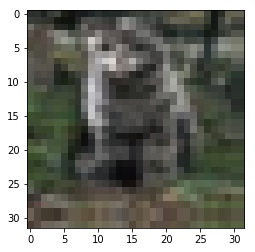

In [65]:
plt.imshow(data.trn_ds.denorm(x)[0])

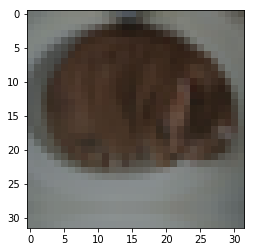

In [66]:
plt.imshow(data.trn_ds.denorm(x)[1])

* Can see that it's hard even for humans to recognise each image.

### 01:08:53 - Simple fully connected model

In [67]:
data = get_data(32, bs)

In [68]:
lr = 1e-2

In [69]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

* Can create a learner from a custom model using `ConvLearner.from_model_data`:

In [70]:
learn = ConvLearner.from_model_data(SimpleNet([32 * 32 * 3, 40, 10]), data)

In [71]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [72]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [73]:
learn.lr_find()

 74%|███████▍  | 145/196 [00:19<00:06,  7.42it/s, loss=11.8]

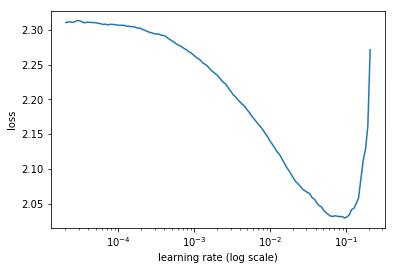

 74%|███████▍  | 145/196 [00:30<00:10,  4.83it/s, loss=11.8]

In [74]:
learn.sched.plot()

In [75]:
lr = 0.001

In [76]:
%time learn.fit(lr, 2)

 22%|██▏       | 43/196 [00:05<00:21,  7.19it/s, loss=2.17]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "//anaconda/envs/fastai-cpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "//anaconda/envs/fastai-cpu/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.933662   1.84444    0.357617  
    1      1.830456   1.749973   0.388574                   

CPU times: user 1min 10s, sys: 37.2 s, total: 1min 47s
Wall time: 56.6 s


[1.7499733, 0.38857421875]

In [79]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.792607   1.722183   0.400586  
    1      1.770955   1.699496   0.411035                   

CPU times: user 1min 11s, sys: 37.2 s, total: 1min 48s
Wall time: 1min


[1.6994957, 0.41103515625]

In [80]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.757154   1.683795   0.418066  
    1      1.742443   1.666395   0.425977                   

CPU times: user 1min 11s, sys: 37.2 s, total: 1min 48s
Wall time: 59.8 s


[1.6663952, 0.4259765625]

* 42% accuracy - not great, but much better than random with 10 classes.

### 01:12:17 - Simple CNN

In [81]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)
        ])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers:
            x = F.relu(l(x))
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)

        return F.log_softmax(self.out(x), dim=-1)

In [82]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

* We pass in a list that includes the input channels to each conv layer: 3 channels in (images with 3 channels), which generates 20 outputs and so on.

In [83]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

* Convolution: find x by x patterns in images that help make predictions.

### 01:17:03 - AdaptiveMaxPool

* Tell model how big final resolution should be, not how big pool should be.
* Standard in modern CNNs: add a 1x1 maxpool layer as second last layer.
  * Gives you a 1x1x filter num output.
  * Feed that into a linear layer with number of classes to predict.

* Fully convolutional network: every layer is a convolution except for the last.

In [84]:
learn.lr_find()

 80%|████████  | 157/196 [00:40<00:10,  3.86it/s, loss=2.23e+03]

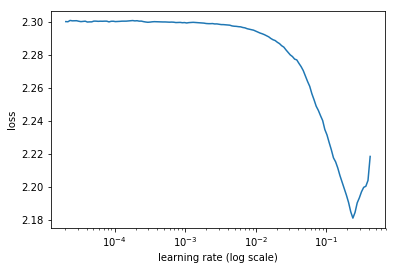

In [85]:
learn.sched.plot()

In [86]:
lr = 0.1

In [87]:
%time learn.fit(1e-1, 2)

  3%|▎         | 5/196 [00:02<01:17,  2.46it/s, loss=2.3]

Exception in thread Thread-17:
Traceback (most recent call last):
  File "//anaconda/envs/fastai-cpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "//anaconda/envs/fastai-cpu/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.706904   1.526245   0.438965  
    1      1.514164   1.45165    0.478711                   

CPU times: user 2min 54s, sys: 52.1 s, total: 3min 46s
Wall time: 1min 48s


[1.4516499, 0.4787109375]

In [88]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.362892   1.287737   0.539844  
    1      1.286068   1.222117   0.561426                   
    2      1.246809   1.189849   0.577539                   
    3      1.203993   1.155248   0.589941                   

CPU times: user 5min 57s, sys: 1min 47s, total: 7min 44s
Wall time: 3min 55s


[1.1552484, 0.58994140625]

* The CNN model has about the quarter of parameters of the fully-connected model.

### 01:21:55 - Refactored model

* Calling `relu` in forward model is "overkill" want to refactor into a ConvLayer class:
  * We added padding in the Conv2d layer.
  * Also, using `adaptive_max_pool2d` as a function, since it doesn't need to store state.

In [90]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x):
        return F.relu(self.conv(x))

In [91]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        
        self.layers = nn.ModuleList(
            [ConvLayer(layers[i], layers[i + 1])
             for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
            
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [92]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

### 01:25:11 - BatchNorm

* One problem with the model is that it can be hard to train for a long time. If the lr is too high, shoots off into `Nan` and too low just takes forever. Enter Batch Normalization.
* Transformative: makes it really easy to train deeper networks.

In [105]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(
            ni, nf, kernel_size=kernel_size,
            stride=stride, bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf, 1, 1))
        self.m = nn.Parameter(torch.ones(nf, 1, 1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0, 1).contiguous().view(x.size(1), -1)
        # Calculate the mean of each filter.
        if self.training:
            self.means = x_chan.mean(1)[:, None, None]
            self.stds = x_chan.std(1)[:, None, None]
        # Subtract the mean and divide by std.
        return (x - self.means) / self.stds * self.m + self.a

In [106]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)
        ])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers:
            x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [107]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [108]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

* Just subtracting the mean and dividing the std is not enough.
  * SGD will keep trying to increase the weight matrix if it thinks it'll help the outcome.
* Instead, introduce params `m` and `a` which allows SGD to undo the normalisation by some amount.
  * Doesn't have to scale up entire matrix: just scales up `m` (same for shifting and `a`).
* Community still not 100% sure why it works.
* Intuition: normalising the data then allowing model to shift it with far fewer params then trying to shift entire set of filters.

### 01:33:16 - Audience questions

* Q1: Are we worried that dividing by a very small `a` we'll have similar problems?
* A1: Maybe. PyTorch library probably adds a little epsilon value.

* Q2: Is `self.m` and `self.a` being updated through backprop?
* A2: Yes. That's why we wrap the weights in ``nn.Parameter``.

### 01:34:09 - Batchnorm as regularisation and layer modes

* Other interesting thing batchnorm does: regularises. Don't need Dropout or L2 regularisation, because it adds noise to the model.
* In real batch norm, you'd take an exponentially weighted moving average of the mean and std.
* Note the `if self.training` to ensure only regularising when training, not when validating/testing.
  * Other types of layers (Dropout, for example) should only be applied during training not evaluation.
  
* In most libraries, batch norm layer is trained whether you set layer trainable or not: very bad idea in a pretrained model as you don't want to change model meaning while training.
* Can unfreeze layer and set `bn_freeze` to freeze batch norm.

### 01:38:25 - Audience questions

* Q1: Does Batch Norm effect performance of model?
* A1: Not much: it is a lot less worth than convs.

* Q2: Where do you put BatchNorm? Before or after relu?
* A2: Usually after Relu.
  * Ablation study: Something where you try turning on and off certain pieces of model, to see what has biggest impact.
    * Originally Batch Norm didn't do this and actually got the batch norm placement wrong.
    
* Q3: Would you test model on smaller dataset, then use bigger one to find ultimate performance?
* A3: Depends on what you're trying to achieve. Small datasets are interesting because lots of people tend to have smaller datasets.

* Q4: (something about the debate about lack of rigour in ML/AI)
* A4: More experiments are most important in deep learning papers.

* Q5: Do you still need to normalise data with batch norm?
* A5: Yes, but you should probably do it anyway. Useful for telling people how you prepared your data.

### 01:47:50 - Modern CNN approach: first conv layer with bigger kernel size

* Want first layer to have a richer input.
* Conv takes a bigger area which allows to find more interesting, richer features in that area.

In [109]:
learn.lr_find()

 90%|█████████ | 177/196 [02:24<00:15,  1.22it/s, loss=nan] 

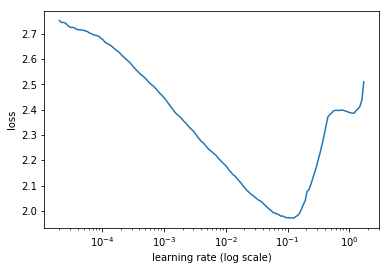

In [110]:
learn.sched.plot()

In [111]:
lr = 0.1

In [112]:
%time learn.fit(lr, 2)

  3%|▎         | 6/196 [00:08<04:25,  1.40s/it, loss=2.57] 


Exception in thread Thread-25:
Traceback (most recent call last):
  File "//anaconda/envs/fastai-cpu/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "//anaconda/envs/fastai-cpu/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.558786   1.379586   0.494629  
    1      1.271849   1.171772   0.57998                    

CPU times: user 8min 15s, sys: 2min 17s, total: 10min 32s
Wall time: 5min 32s


[1.1717718, 0.57998046875]

In [113]:
%time learn.fit(lr, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.090187   1.036797   0.635547  
    1      1.042354   0.984785   0.65459                    
    2      0.980663   0.931726   0.673535                    
    3      0.941407   0.903323   0.684375                    

CPU times: user 16min 56s, sys: 4min 57s, total: 21min 54s
Wall time: 14min 26s


[0.90332335, 0.684375]

In [114]:
%time learn.fit(lr, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.907855   0.885311   0.69541   
    1      0.872077   0.842913   0.703027                    
    2      0.84367    0.810211   0.714844                    
    3      0.823831   0.783214   0.725391                    

CPU times: user 17min 39s, sys: 4min 31s, total: 22min 11s
Wall time: 13min 40s


[0.7832139, 0.725390625]

* Seems to be doing a lot better. Batch norm works!
* Can we go deeper?

## 01:50:54 - Deeper BatchNorm

* Can a deeper model improve upon our performance?
* For each filter, run the first convolution, then a second with stride one.
  * Stride 1 doesn't change the size (same amount of convolutions as pixels) = same size at each step but twice the convolutions.

In [121]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            BnLayer(layers[i], layers[i + 1])
                for i in range(len(layers) - 1)])

        self.layers2 = nn.ModuleList([
            BnLayer(layers[i + 1], layers[i + 1])
                for i in range(len(layers) - 1)])
        
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l, l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        
        return F.log_softmax(self.out(x), dim=-1)

In [122]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

* Actually doesn't help that much: "too deep for batch norm to deal with"

### 01:52:10 - ResNet

* Replace BnLayer with one that adds the orignal layer.

* Start with $y = x + f(x)$ function described in `forward`.
* Can be rewritten as $f(x) = y - x$
* Trying to fit a function describing the difference between the two aka "residual".
    * In other words, find weights that make up for the amount I was off by.
* Each layer returns the residual, then the next layer predicts that residual, which then is added to the result and the residual of residual is predicted.
* Similar to boosting.

In [125]:
class ResnetLayer(BnLayer):
    def forward(self, x):
        return x + super().forward(x)

In [136]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        
        # Note: Resnet layers below
        self.layers2 = nn.ModuleList([
            ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([
            ResnetLayer(layers[i+1], layers[i+1], 1) for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [137]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

* Full Resnet block has 2 convolution, not just one.
* Usually represented like this:

<img src="https://i.gyazo.com/33a35a84518ec459a1ce5021c3bedd9c.gif">

* First block is a standard convolution with stride of 2: not a Resnet.
  * Called "bottleneck" block.
  * Actual ResNet doesn't do a convolution here: covered in Part 2.

In [138]:
wd = 1e-5

In [139]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.578736   1.439864   0.474219  
    1      1.349992   1.233804   0.561816                   

CPU times: user 20min 59s, sys: 4min 51s, total: 25min 50s
Wall time: 15min 4s


[1.2338041, 0.56181640625]

In [140]:
%time learn.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.16051    1.101358   0.602148  
    1      1.111677   1.037911   0.63418                    
    2      0.978961   0.946352   0.662402                    
    3      1.017637   0.956744   0.659277                   
    4      0.884918   0.851599   0.698242                    
    5      0.785012   0.807248   0.716699                    
    6      0.742333   0.773387   0.726855                    

CPU times: user 1h 13min 9s, sys: 16min 34s, total: 1h 29min 44s
Wall time: 54min 27s


[0.77338713, 0.72685546875]

* Jeremy adds more layers and eventually gets a result of 0.85.
* Best results now are around 97% but still all based on these results.
  * Better approaches to data augmentation
  * Better ResNet approaches.
  * Better regularisation.

### 02:01:05 - Audience questions

* Q1: Can ResNet be applied to non-image problems?
* A1: Yes, but it has been largely ignored outside of computer vision. Though, in NLP there's a Transformer architecture that has a ResNet-like structure.
  * "Skip connections" could be useful in NLP.

## 02:02:03 - Dogs and Cats revisited

In [205]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.fastai.imports import *
from fastai.fastai.conv_learner import *
from fastai.fastai.model import *
from fastai.fastai.dataset import *
from fastai.fastai.sgdr import *

In [206]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

### Prepare data (again)

In [148]:
!cd data && wget http://files.fast.ai/data/dogscats.zip

--2018-05-13 20:58:56--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai... 67.205.15.147
Connecting to files.fast.ai|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  3.38MB/s    in 4m 10s  

2018-05-13 21:03:07 (3.27 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



In [153]:
!cd data && unzip -q dogscats.zip

In [180]:
!ls {PATH}

models sample test1  tmp    train  valid


In [210]:
base_model = arch(True)

In [211]:
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

* Can replace layer, similar to what ConvLearning is doing.
* Fast.ai replaced the `AvgPool2d` layer, with adaptive average pooling and adaptive max pooling, then concats them.

* Replace the last layer with a `Sequential` last layer which includes the following:
  * A ConvLayer which outputs 2 filters and does average pool to produce only 2 numbers.

In [212]:
m = nn.Sequential(
    *children(base_model)[:-2],
    nn.Conv2d(512, 2, 3, padding=1),
    nn.AdaptiveAvgPool2d(1), Flatten(),
    nn.LogSoftmax())

In [213]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [214]:
learn = ConvLearner.from_model_data(m, data)

In [215]:
learn.freeze_to(-4)

In [216]:
m[-1].trainable

True

In [217]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.208741   0.101723   0.990723  



[0.10172296, 0.99072265625]

In [218]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                       
    0      0.154342   0.086851   0.989746  



[0.0868506, 0.98974609375]

## 02:08:54 - Class Activation Maps (CAM)

* Try to look at an image and ask which parts of image are important.

In [235]:
class SaveFeatures():
    
    features = None
    
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output
        
    def remove(self):
        self.hook.remove()

In [248]:
x, y = next(iter(data.val_dl))

In [249]:
x, y = x[None, 2], y[None, 2]
vx = Variable(x, requires_grad=True)

In [250]:
dx = data.val_ds.denorm(x)[0]

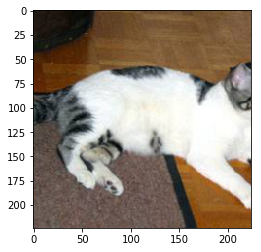

In [251]:
plt.imshow(dx)

In [252]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [253]:
%time py = m(Variable(x))

CPU times: user 305 ms, sys: 52.1 ms, total: 358 ms
Wall time: 193 ms


In [254]:
for o in sfs: o.remove()

In [255]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [256]:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [257]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [258]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.21678, 0.32037, 0.339  , 0.31979, 0.27854, 0.219  , 0.09727],
       [0.35329, 0.53101, 0.57583, 0.60583, 0.57986, 0.43674, 0.16619],
       [0.49981, 0.71209, 0.75462, 0.80085, 0.84825, 0.70172, 0.31303],
       [0.46067, 0.69794, 0.79908, 0.91583, 1.     , 0.81631, 0.35265],
       [0.2966 , 0.50397, 0.65889, 0.82265, 0.95597, 0.83585, 0.37091],
       [0.08441, 0.25684, 0.47304, 0.66767, 0.77201, 0.67718, 0.30872],
       [0.     , 0.09539, 0.22392, 0.35362, 0.4304 , 0.41082, 0.22393]], dtype=float32)

//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


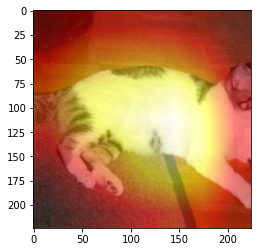

In [259]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');